In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from wordcloud import WordCloud, STOPWORDS
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
        
#import surprise
#from surprise import Reader
#from surprise import Dataset
#from surprise.model_selection import train_test_split
import time
#from surprise import SVD
#from surprise import accuracy
import re
import plotly.express as px
import scipy as sp
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline  import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, Normalizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

In [39]:
#data_folder = '/kaggle/input/edsa-recommender-system-predict/'
data = 'C:/Users/u1121/Desktop/Explore/sprints/7. Unsupervised learning 11_04_2021/predict/data/'
train_df = pd.read_csv(data + 'train.csv')
test_df = pd.read_csv(data + 'test.csv')
tags_df = pd.read_csv(data + 'tags.csv')
movies_df = pd.read_csv(data + 'movies.csv')
links_df = pd.read_csv(data + 'links.csv')
imdb_df = pd.read_csv(data + 'imdb_data.csv')
genome_tags_df = pd.read_csv(data + 'genome_tags.csv')
genome_score_df = pd.read_csv(data + 'genome_scores.csv')

In [40]:
train_df.head(2)
#two features, rating and timestamp

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739


In [41]:
train_df.info()
#10 000 038 entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [42]:
len(train_df['movieId'].unique())
#48 213 movies

48213

In [43]:
len(train_df['userId'].unique())
#162 541 moviees

162541

Users have rated multiple movies 

In [44]:
test_df.head(2)

,userId,movieId
0,1,2011
1,1,4144


In [45]:
tags_df.head(2)
#tags possible new feature to improve recommender

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256


In [46]:
len(tags_df['movieId'].unique())
#45 251 movies, some are missing

45251

In [47]:
movies_df.head(2)
#what is the difference between genre and tag?

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [48]:
tags_df['tag'].unique()

array(['classic', 'sci-fi', 'dark comedy', ..., 'genre busting',
       'the wife did it', 'cornetto triolgy'], dtype=object)

In [49]:
movies_df['genres'].unique()
#genre and tag not the same

array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance', ...,
       'Children|Comedy|Fantasy|Mystery', 'Children|Comedy|Crime|Fantasy',
       'Comedy|Horror|Mystery|Sci-Fi|Western'], dtype=object)

In [50]:
links_df.head(2)
#??

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [51]:
imdb_df.head(2)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game


A genome tag is a single characteristic exhibited by a movie (for example, atmospheric, thought-provoking, realistic, etc.). Each genome tag score reflects the relevance of a tag to a movie on a scale of 0 to 1.

In [52]:
genome_tags_df.head(2)

,tagId,tag
0,1,007
1,2,007 (series)


In [53]:
genome_score_df.head(2)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375


### EDA

In [54]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [55]:
train_df = train_df.sort_values(by=['rating'], ascending=False)
train_df.head()

,userId,movieId,rating,timestamp
3933573,118176,593,5.0,1197630915
7585778,32810,4282,5.0,1111718329
7585749,66818,1096,5.0,931950762
1564921,148022,2064,5.0,945887531
1564920,144508,589,5.0,838570244


Range of ratings

C:\Users\u1121\anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\u1121\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Average rating in dataset: 3.5333951730983424


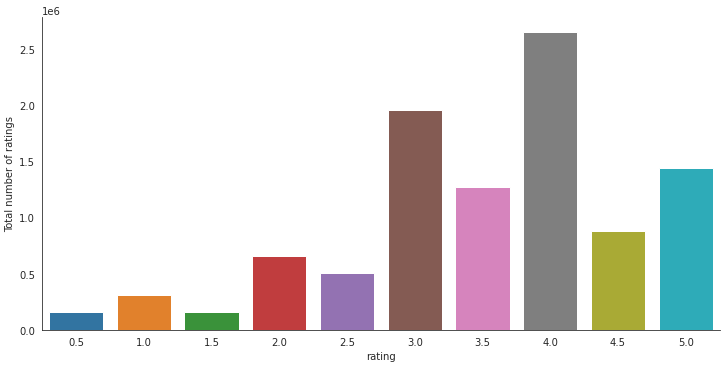

In [56]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=train_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(train_df["rating"])}')

##### Rating count

In [57]:
# To find the number of times a user rated a movie, we create a data frame with the count by userId
user = pd.DataFrame(
    train_df['userId'].value_counts()).reset_index()
user.rename(columns={'index':'userId','userId':'rating count'},
                  inplace=True)

user = user.sort_values(by=['rating count'], ascending=False)
user.head()

,userId,rating count
0,72315,12952
1,80974,3680
2,137293,3588
3,33844,3208
4,20055,3050


User 72315 seems to be an outlier??

### Movies Dataset

In [58]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [59]:
movies_df.shape

(62423, 3)

In [60]:
genres = pd.DataFrame(movies_df['genres'].
                      str.split("|").
                      tolist(),
                      index=movies_df['movieId']).stack()
genres = genres.reset_index([0, 'movieId'])
genres.columns = ['movieId', 'Genre']
genres.head(15)

,movieId,Genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy
5,2,Adventure
6,2,Children
7,2,Fantasy
8,3,Comedy
9,3,Romance


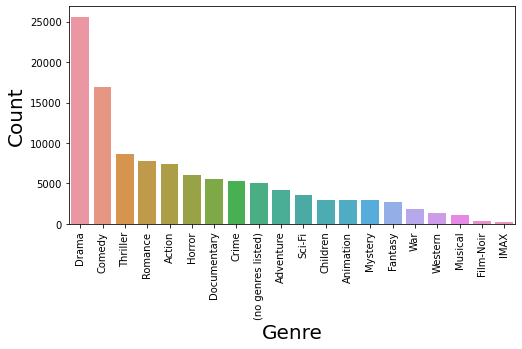

In [61]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(x='Genre',
              data=genres,
              order=genres['Genre'].
              value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Genre', size=20)
plt.ylabel('Count', size=20)
plt.show()

Most rated movies  (mrm)

In [62]:
movies=pd.merge(train_df, movies_df,on='movieId',how='inner')
movies['time']=movies['title'].str.slice(-5, -1)
movies.head()

,userId,movieId,rating,timestamp,title,genres,time
0,118176,593,5.0,1197630915,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991
1,31411,593,5.0,844428685,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991
2,125264,593,5.0,970251499,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991
3,108849,593,5.0,1360712319,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991
4,120349,593,5.0,840732206,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991


In [70]:
table = pd.pivot_table(movies, values =['rating'], index =['title', 'time','movieId'], aggfunc='count')
table = table.sort_values(by=['rating'], ascending=False)
table = table.reset_index()
table.rename(columns={'rating':'rating count'},
                  inplace=True)
result = table.truncate(after = 9)
result = result.sort_values(by=['time'], ascending=False)
result

,title,time,movieId,rating count
4,"Matrix, The (1999)",1999,2571,29014
9,Fight Club (1999),1999,2959,23536
8,Braveheart (1995),1995,110,23722
0,"Shawshank Redemption, The (1994)",1994,318,32831
1,Forrest Gump (1994),1994,356,32383
2,Pulp Fiction (1994),1994,296,31697
6,Jurassic Park (1993),1993,480,25518
7,Schindler's List (1993),1993,527,24004
3,"Silence of the Lambs, The (1991)",1991,593,29444
5,Star Wars: Episode IV - A New Hope (1977),1977,260,27560


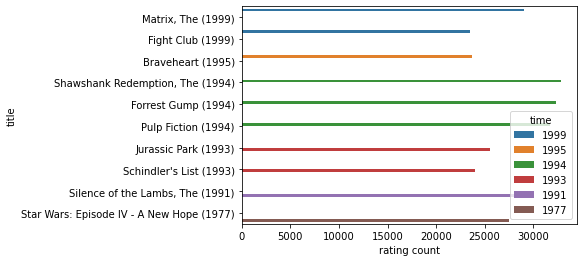

In [68]:
p = sns.barplot(data=result, x='rating count',y='title', hue='time')

In [69]:
#plt.figure(figsize=(20, 10))
#result.plot(x='time', y='rating count', kind='bar', color=['yellow', 'red', 'green', 'blue', 'cyan'])

##### Tags

In [31]:
new_train=train_df.drop(['userId', 'timestamp'], axis = 1, )
new_train['movieId'] = new_train['movieId'].astype('int16', errors="ignore")
new_train['rating'] = new_train['rating'].astype('float16', errors="ignore")
new_train.info()
#10 000 038

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   movieId  int16  
 1   rating   float16
dtypes: float16(1), int16(1)
memory usage: 38.1 MB


In [36]:
new_tags=tags_df.drop(['userId', 'timestamp'], axis = 1, )
new_tags['movieId'] = new_tags['movieId'].astype('int16', errors="ignore")
new_tags['tag'] = new_tags['tag'].astype('category', errors="ignore")
new_tags.info()
#1 093 360

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype   
---  ------   --------------    -----   
 0   movieId  1093360 non-null  int16   
 1   tag      1093344 non-null  category
dtypes: category(1), int16(1)
memory usage: 8.8 MB


In [77]:
tags=pd.merge(result, new_tags,on='movieId',how='inner')
tags.shape

(30226, 5)

Text(0.5, 1.0, 'Tags for highly rated movies')

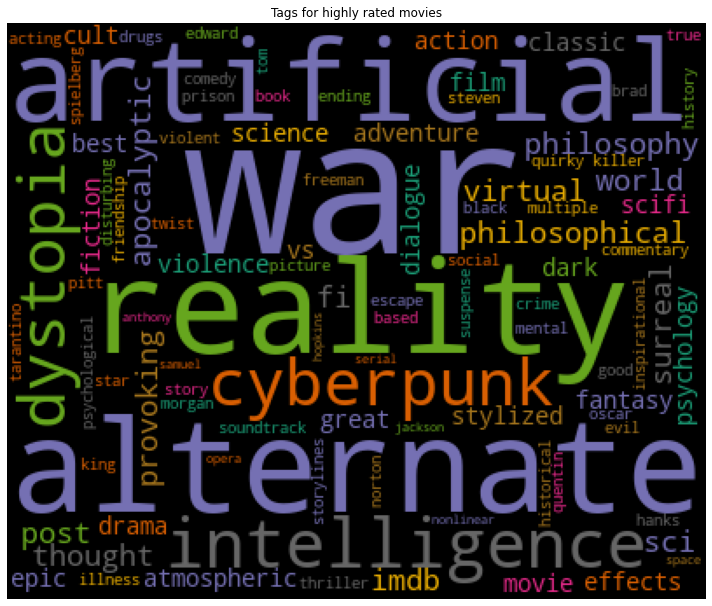

In [76]:
#create instance of WordCloud
wc=WordCloud(width=400, height=330, max_words=150,colormap="Dark2")

#Create string of 100 words
wcVect = CountVectorizer(stop_words='english',max_features=100) 
wcVect.fit(tags['tag'])
text1=list(wcVect.vocabulary_)
text2=string = ' '.join(text1)

text2
#createWordCloud
a=wc.generate(string)

plt.figure(figsize = (14, 8), facecolor = None)
plt.imshow(a)
plt.axis("off")
plt.tight_layout(pad = 0);

plt.title("Tags for highly rated movies")